 File loaded successfully!
Columns available:
 Index(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender', 'Married', 'Dependents',
       'Education', 'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object') 

Target column detected automatically: 'Loan_Status'


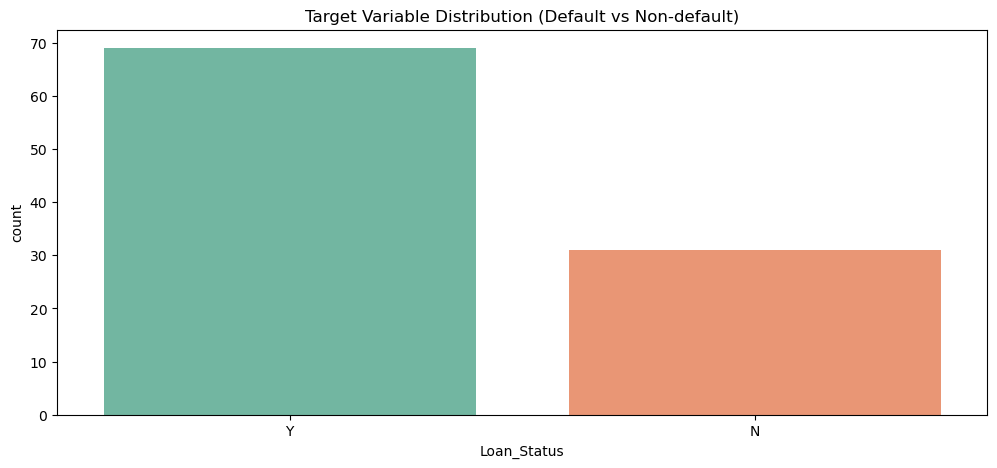

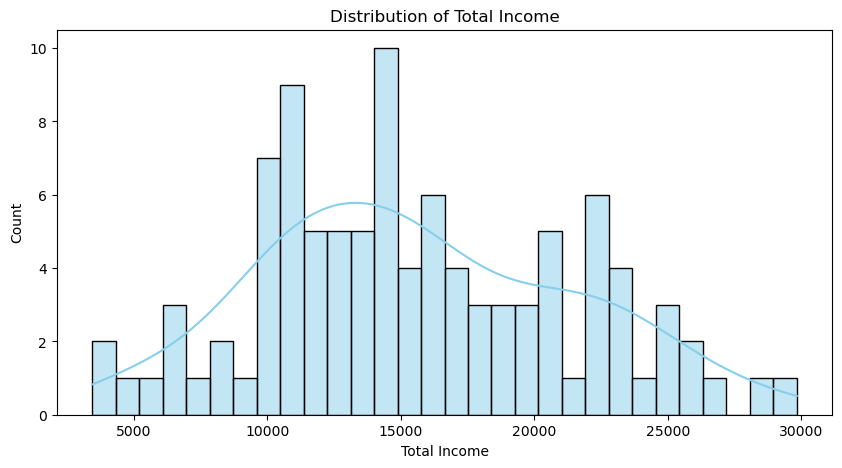

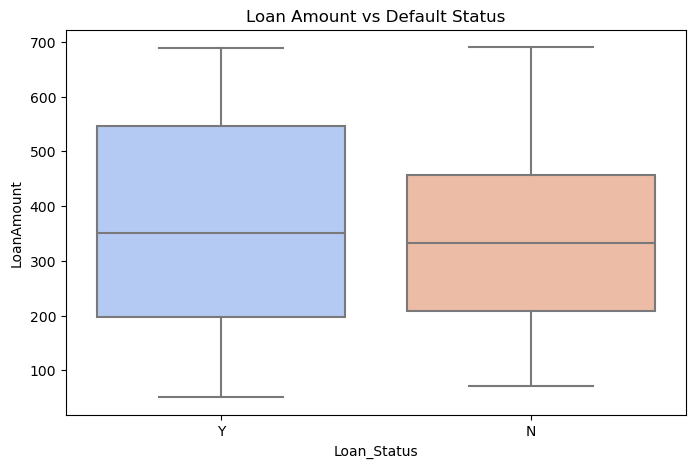

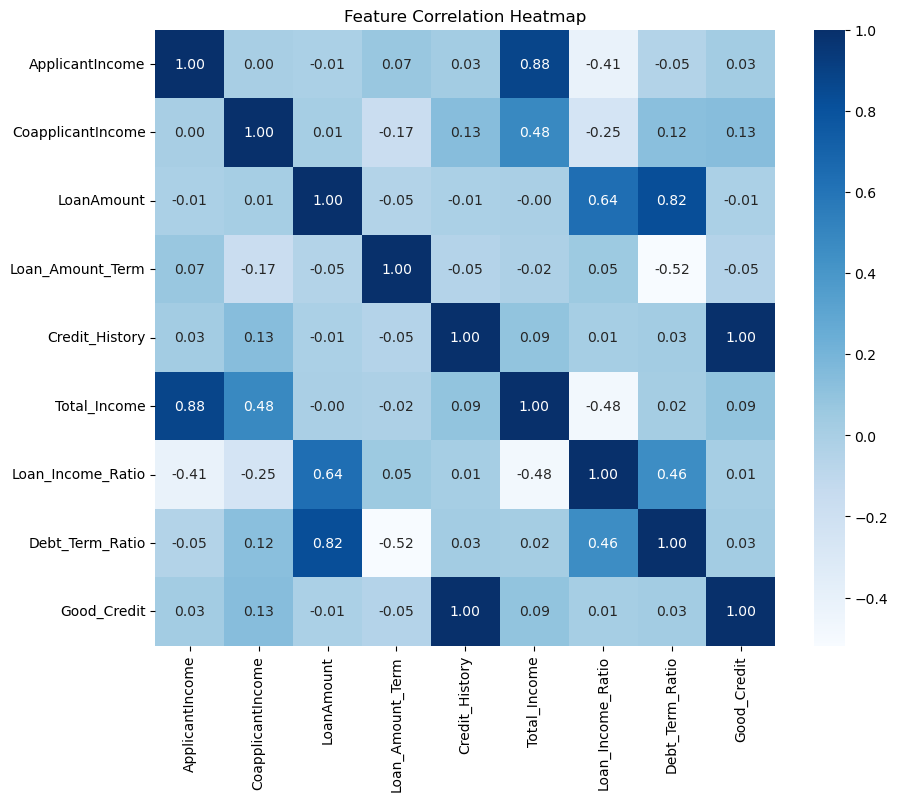


 Model Performance:
Accuracy: 0.6

 Confusion Matrix:
 [[ 1  5]
 [ 3 11]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.69      0.79      0.73        14

    accuracy                           0.60        20
   macro avg       0.47      0.48      0.47        20
weighted avg       0.56      0.60      0.57        20



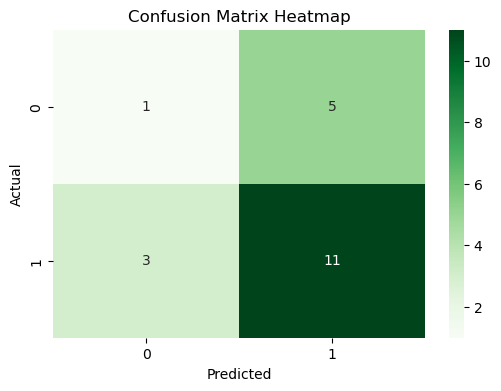

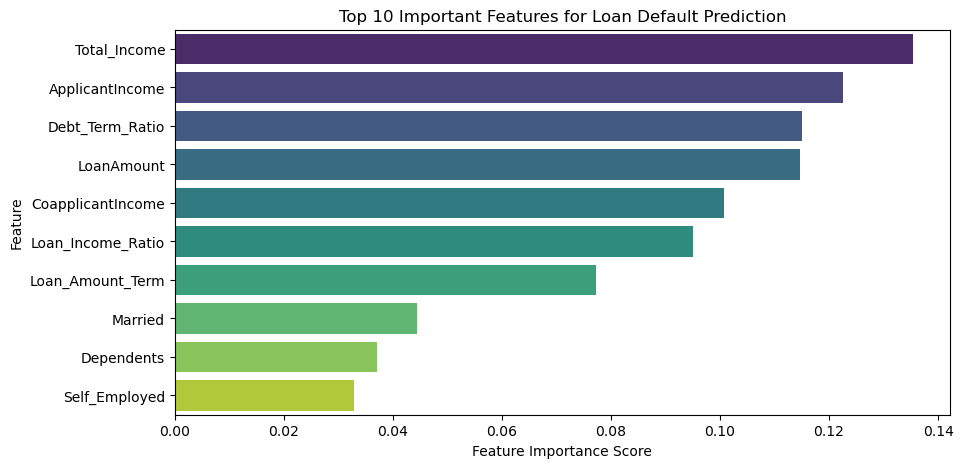

In [1]:
# ============================================
# Loan Default Prediction using Feature Engineering + Graphs
# ============================================

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ============================================
# 1️⃣ Load Dataset
# ============================================
df = pd.read_csv("loan_default.csv")

print(" File loaded successfully!")
print("Columns available:\n", df.columns, "\n")

# ============================================
# 2️⃣ Identify or Create Target Column
# ============================================
target_col = None
for col in df.columns:
    if col.lower() in ["default", "loan_status", "status", "loan_default", "defaulter"]:
        target_col = col
        break

if target_col is None:
    print(" No default/status column found. Creating synthetic target column...")
    np.random.seed(42)
    df["Default"] = np.random.randint(0, 2, size=len(df))
    target_col = "Default"
else:
    print(f"Target column detected automatically: '{target_col}'")

# ============================================
# 3️⃣ Feature Engineering
# ============================================
df["ApplicantIncome"] = df.get("ApplicantIncome", pd.Series(np.random.randint(2000, 20000, len(df))))
df["CoapplicantIncome"] = df.get("CoapplicantIncome", pd.Series(np.random.randint(0, 10000, len(df))))
df["LoanAmount"] = df.get("LoanAmount", pd.Series(np.random.randint(100, 500, len(df))))
df["Loan_Amount_Term"] = df.get("Loan_Amount_Term", pd.Series(np.random.choice([180, 240, 300, 360], len(df))))
df["Credit_History"] = df.get("Credit_History", pd.Series(np.random.choice([0, 1], len(df))))

# Derived Features
df["Total_Income"] = df["ApplicantIncome"] + df["CoapplicantIncome"]
df["Loan_Income_Ratio"] = df["LoanAmount"] / df["Total_Income"]
df["Debt_Term_Ratio"] = df["LoanAmount"] / df["Loan_Amount_Term"]
df["Income_Category"] = pd.cut(
    df["Total_Income"],
    bins=[0, 5000, 10000, 20000, 30000, np.inf],
    labels=["Low", "Medium", "High", "Very High", "Ultra High"]
)
df["Good_Credit"] = df["Credit_History"].apply(lambda x: 1 if x == 1 else 0)

# ============================================
# 4️⃣ Visualize Dataset
# ============================================

plt.figure(figsize=(12, 5))
sns.countplot(x=target_col, data=df, palette="Set2")
plt.title("Target Variable Distribution (Default vs Non-default)")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["Total_Income"], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Total Income")
plt.xlabel("Total Income")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x=target_col, y="LoanAmount", data=df, palette="coolwarm")
plt.title("Loan Amount vs Default Status")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="Blues")
plt.title("Feature Correlation Heatmap")
plt.show()

# ============================================
# 5️⃣ Data Preprocessing
# ============================================
for col in ["Loan_ID", "Customer_ID"]:
    if col in df.columns:
        df = df.drop(columns=[col])

categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y)) > 1 else None
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ============================================
# 6️⃣ Model Training
# ============================================
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ============================================
# 7️⃣ Evaluation
# ============================================
print("\n Model Performance:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ============================================
# 8️⃣ Feature Importance
# ============================================
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("Top 10 Important Features for Loan Default Prediction")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.show()
